# Ablation study

**Objetivo:** Comparar los resultados obtenidos en los distintos pasos vs un enfoque baseline


# Dependencies

In [1]:
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from dowhy import CausalModel
from castle.common import GraphDAG
from castle.algorithms import PC
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.search.ScoreBased.GES import ges

from config import TREATMENT, OUTCOME, SEED
from utils.graphs import (
    get_nx_graph_FCI,
    create_prior,
    get_edges_list_from_gcastlegraph,
    analyze_dag_issues,
    make_dag,
    get_outcome_only_causes,
    get_nx_graph_ges,
    redirect_edges_by_domain_knownledge,
)


from utils.preprocessing import create_stratification_split_col

warnings.filterwarnings("ignore")

2025-02-07 16:21:06,004 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\castle\backend\__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2025-02-07 16:21:06,070 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\castle\algorithms\__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


# Environment variables

In [2]:
CONTROLS_PATH = "data/controls.txt"
OUTCOME_CAUSES_PATH = "data/outcome_causes.txt"

In [3]:
np.random.seed(SEED)

# Utils

# Data

In [4]:
df_original = pd.read_parquet("data/synthetic_data.parquet")

# Split

In [5]:
strat_feature = create_stratification_split_col(df_original, TREATMENT, OUTCOME)
train, test = train_test_split(
    df_original, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=strat_feature,
)


X_train, y_train = (
    train.drop(columns=[OUTCOME]).copy(),
    train[[OUTCOME]],
)
X_test, y_test = (
    test[X_train.columns],
    test[[OUTCOME]],
)
test_original = df_original.loc[test.index, :]
print(X_train.shape, X_test.shape)

(12000, 411) (3000, 411)


In [6]:
# Scale
features_scale = list(X_train.columns)
train_scaled = train.copy()
test_scaled = test.copy()

scaler = StandardScaler()
train_scaled[features_scale] = pd.DataFrame(
    scaler.fit_transform(train[features_scale]), columns=features_scale, index=train.index
)
test_scaled[features_scale] = pd.DataFrame(
    scaler.transform(test[features_scale]), columns=features_scale, index=test.index
)

# Identification without dimensionality reduction

In [7]:
features_graph = list(X_train.columns) + [OUTCOME]

## PC

In [8]:
# gcastle
priori = create_prior(
    train[features_graph],
    "gcastle",
    TREATMENT,
    OUTCOME,
    "pc",
    force_treatmemnt_output=True,
)

pc_gcstle = PC(variant="original", alpha=0.01, ci_test="fisherz", priori_knowledge=priori)
pc_gcstle.learn(train_scaled[features_graph])

print(pc_gcstle.causal_matrix)

# plot predict_dag and true_dag
GraphDAG(pc_gcstle.causal_matrix)

# add edges from a list of tuples
edges_list = get_edges_list_from_gcastlegraph(pc_gcstle, features_graph)

# create a directed graph
pc_G = nx.DiGraph()
pc_G.add_edges_from(edges_list)

# draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    pc_G,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    pos=nx.circular_layout(pc_G),
)
plt.show()

KeyboardInterrupt: 

In [ ]:
# First analyze the issues
problematic_edges = analyze_dag_issues(pc_G)

# If you want to automatically fix it
if len(problematic_edges) > 0:
    pc_G = make_dag(pc_G)

Found cycles:
redundantfeature81_debt_cirbe -> debt_cirbe -> redundantfeature81_debt_cirbe
redundantfeature45_debt_cirbe -> debt_cirbe -> redundantfeature45_debt_cirbe
redundantfeature80_debt_cirbe -> debt_cirbe -> redundantfeature80_debt_cirbe
debt_cirbe -> redundantfeature39_debt_cirbe -> debt_cirbe
debt_cirbe -> redundantfeature100_debt_cirbe -> debt_cirbe
redundantfeature52_months_since_first_payment -> months_since_first_payment -> redundantfeature52_months_since_first_payment
redundantfeature72_months_since_first_payment -> months_since_first_payment -> redundantfeature72_months_since_first_payment
redundantfeature21_months_since_first_payment -> months_since_first_payment -> redundantfeature21_months_since_first_payment
months_since_first_payment -> redundantfeature9_months_since_first_payment -> months_since_first_payment
redundantfeature85_n_refin -> n_refin -> redundantfeature85_n_refin
redundantfeature20_n_refin -> n_refin -> redundantfeature20_n_refin
redundantfeature79_n_l

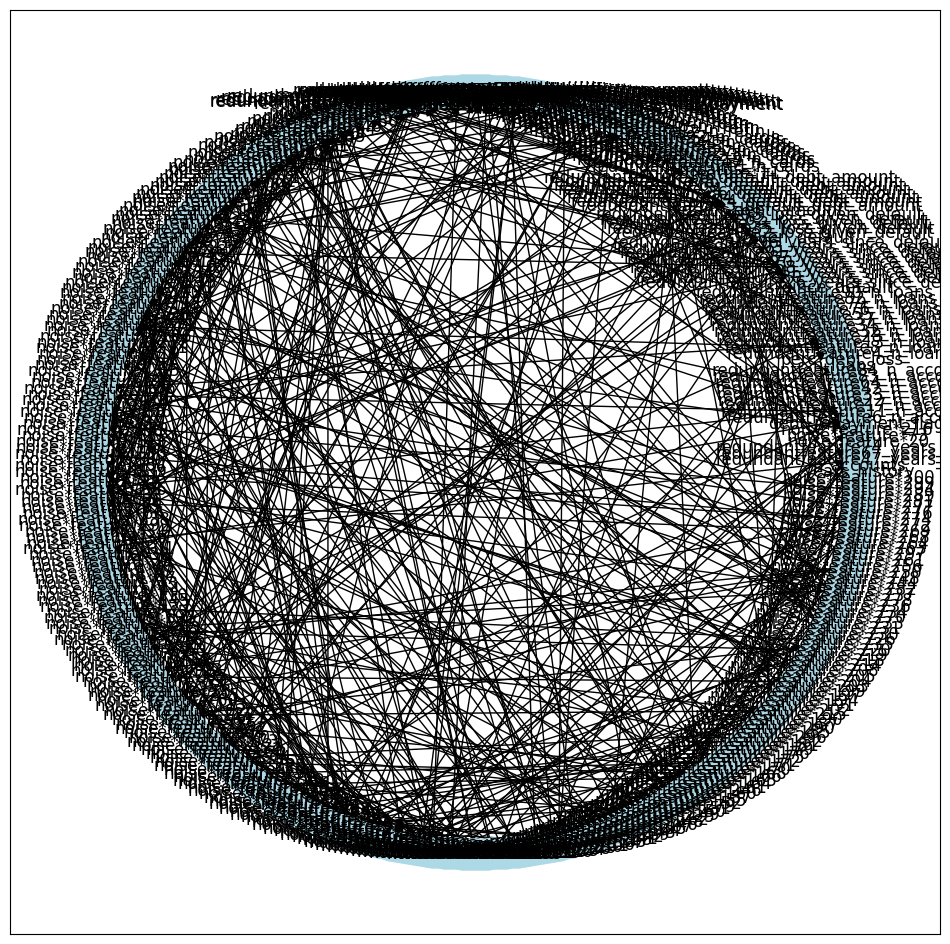

In [ ]:
edges_list = [e for e in pc_G.edges]
if (TREATMENT, OUTCOME) not in edges_list:
    pc_G.add_edge(TREATMENT, OUTCOME)
    
# draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    pc_G,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    pos=nx.circular_layout(pc_G),
)
plt.show()

In [ ]:
model_pc = CausalModel(
    data=train[features_graph],
    treatment=TREATMENT,
    outcome=OUTCOME,
    graph="\n".join(nx.generate_gml(pc_G)),
)

# Identify the effect
identified_estimand_pc = model_pc.identify_effect()

print(identified_estimand_pc)

2025-02-06 08:45:00,267 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_model.py[line:505] - INFO: Model to find the causal effect of treatment ['perc_debt_loss'] on outcome ['debt_repayment_flag']
2025-02-06 08:45:00,268 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_model.py[line:613] - WARNING: There are an additional 12 variables in the dataset that are not in the graph. Variable names are: '['noise*feature*153', 'noise*feature*183', 'noise*feature*193', 'noise*feature*200', 'noise*feature*25', 'noise*feature*254', 'noise*feature*287', 'noise*feature*293', 'noise*feature*4', 'noise*feature*55', 'noise*feature*67', 'noise*feature*81']'
2025-02-06 10:36:59,481 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_identifier\auto_identifier.py[line:763] - INFO: Causal effect can be identified.
2025-02-06 10:36:59,489 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
─────────────────(E[debt_repayment_flag|loss_given_default,n_loans,years_since
d[perc_debt_loss]                                                             

          
_default])
          
Estimand assumption 1, Unconfoundedness: If U→{perc_debt_loss} and U→debt_repayment_flag then P(debt_repayment_flag|perc_debt_loss,loss_given_default,n_loans,years_since_default,U) = P(debt_repayment_flag|perc_debt_loss,loss_given_default,n_loans,years_since_default)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                                            
 ⎢                         d                                                ⎛ 
E⎢────────────────────────────────────────────────────(debt_repayment_flag)⋅⎜─
 ⎣d[default_debt_amount  debt_cirbe  n_cards  n_refin]    

In [ ]:
estimate = model_pc.estimate_effect(
    identified_estimand_pc,
    method_name="backdoor.linear_regression",
    test_significance=True,
)
print(estimate)

2025-02-06 10:36:59,748 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_model.py[line:329] - INFO: linear_regression
2025-02-06 10:36:59,749 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_estimators\linear_regression_estimator.py[line:70] - INFO: INFO: Using Linear Regression Estimator
2025-02-06 10:36:59,754 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_estimators\regression_estimator.py[line:147] - INFO: b: debt_repayment_flag~perc_debt_loss+loss_given_default+n_loans+years_since_default+perc_debt_loss*noise*feature*252+perc_debt_loss*noise*feature*223+perc_debt_loss*noise*feature*194+perc_debt_loss*redundantfeature30_years_since_default+perc_debt_loss*noise*feature*98+perc_debt_loss*noise*feature*92+perc_debt_loss*noise*feature*53+perc_debt_loss*noise*feature*19+perc_debt_loss*noise*feature*21+perc_debt_loss*noise*feature*79+perc_debt_loss*noise*feature*96+perc_debt_loss*noise*feature*

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
─────────────────(E[debt_repayment_flag|loss_given_default,n_loans,years_since
d[perc_debt_loss]                                                             

          
_default])
          
Estimand assumption 1, Unconfoundedness: If U→{perc_debt_loss} and U→debt_repayment_flag then P(debt_repayment_flag|perc_debt_loss,loss_given_default,n_loans,years_since_default,U) = P(debt_repayment_flag|perc_debt_loss,loss_given_default,n_loans,years_since_default)

## Realized estimand
b: debt_repayment_flag~perc_debt_loss+loss_given_default+n_loans+years_since_default+perc_debt_loss*noise*feature*252+perc_debt_loss*noise*feature*223+perc_debt_loss*noise*feature*194+perc_debt_loss*redundantfeature30_years_since_default+perc_debt_loss*noise*feature*98+perc_debt_lo

In [ ]:
backdoor_variables_pc = identified_estimand_pc.get_backdoor_variables()
print("Backdoor adjustment set PC:", backdoor_variables_pc)

Backdoor adjustment set FCI: ['loss_given_default', 'n_loans', 'years_since_default']


In [ ]:
outcome_causes_pc = get_outcome_only_causes(pc_G, OUTCOME, TREATMENT)

Features that cause ONLY the outcome: ['years_history', 'n_accounts', 'redundantfeature30_years_since_default', 'months_since_first_payment', 'noise*feature*98', 'noise*feature*102']


## FCI

  0%|          | 0/412 [00:00<?, ?it/s]

Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X412
Orienting edge (Knowledge): X2 --> X412
Orienting edge (Knowledge): X3 --> X11
Orienting edge (Knowledge): X3 --> X412
Orienting edge (Knowledge): X4 --> X11
Orienting edge (Knowledge): X4 --> X412
Orienting edge (Knowledge): X5 --> X11
Orienting edge (Knowledge): X5 --> X412
Orienting edge (Knowledge): X6 --> X11
Orienting edge (Knowledge): X7 --> X11
Orienting edge (Knowledge): X8 --> X11
Orienting edge (Knowledge): X9 --> X412
Orienting edge (Knowledge): X10 --> X11
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X1 --> X412
Orienting edge (Knowledge): X2 --> X412
Orienting edge (Knowledge): X3 --> X11
Orienting edge (Knowledge): X3 --> X412
Orienting edge (Knowledge): X4 --> X11
Orienting edge (Knowledge): X4 --> X412
Orienting edge (Knowledge): X5 --> X11
Orienting edge (Knowledge): X5 --> X412
Orienting edge (Knowledge): X6 --> X11
Orienting edge (Knowledge): X7 --> X11
Orienting edge 

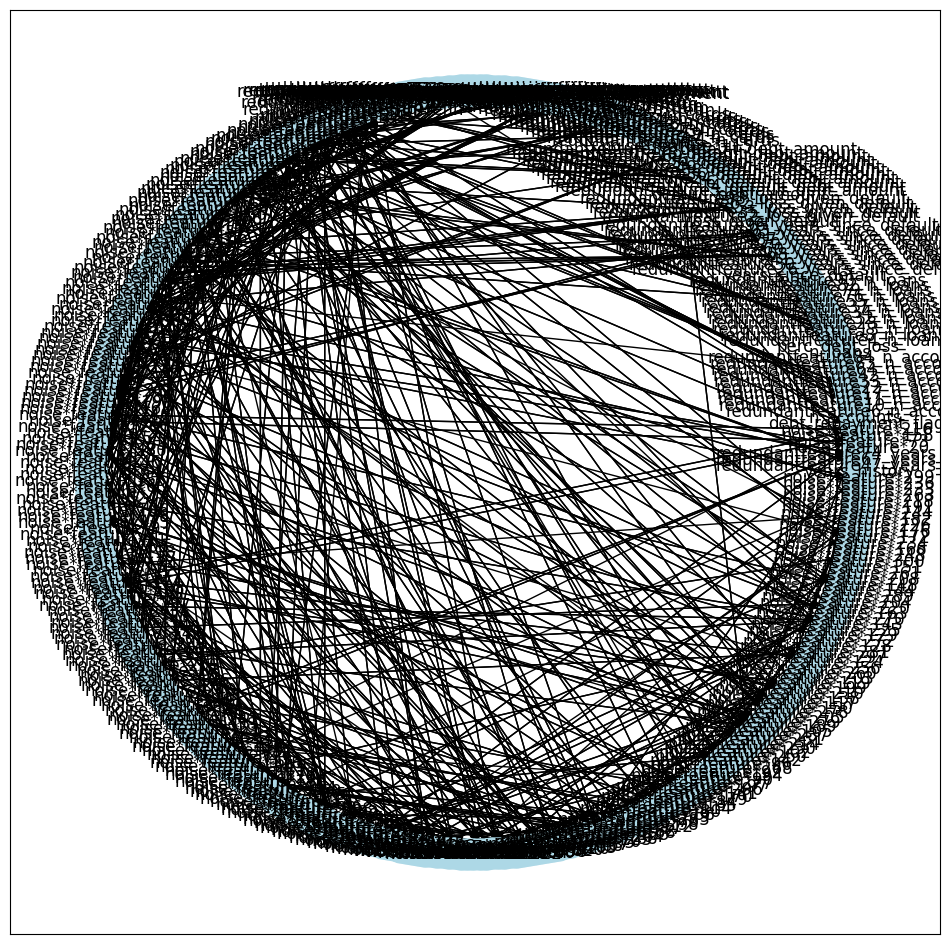

In [22]:
priori = create_prior(
    train_scaled[features_graph],
    "causal-learn",
    TREATMENT,
    OUTCOME,
    "fci",
    force_treatmemnt_output=True,
)

# or customized parameters
graph_fci, edges = fci(
    dataset=train_scaled[features_graph].to_numpy(),
    independence_test_method="fisherz",  # kci
    background_knowledge=priori,
    alpha=0.01,
)

fci_G = get_nx_graph_FCI(graph_fci.graph, features_graph)

# draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    fci_G,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    pos=nx.circular_layout(fci_G),
)
plt.show()

In [23]:
# First analyze the issues
problematic_edges = analyze_dag_issues(fci_G)
print(len(problematic_edges))

# If you want to automatically fix it
if len(problematic_edges) > 0:
    fci_G = make_dag(fci_G)

AttributeError: module 'networkx' has no attribute 'NetworkXNonImplemented'

In [1]:
# force connection
edges_list = [e for e in fci_G.edges]
if (TREATMENT, OUTCOME) not in edges_list:
    fci_G.add_edge(TREATMENT, OUTCOME)

# draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    fci_G,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    pos=nx.circular_layout(fci_G),
)
plt.show()

NameError: name 'fci_G' is not defined

In [27]:
model_fci = CausalModel(
    data=train[features_graph],
    treatment=TREATMENT,
    outcome=OUTCOME,
    graph="\n".join(nx.generate_gml(fci_G)),
)

# Identify the effect
identified_estimand_fci = model_fci.identify_effect()

print(identified_estimand_fci)

2025-01-19 19:38:08,930 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_model.py[line:505] - INFO: Model to find the causal effect of treatment ['perc_debt_forgivness'] on outcome ['debt_repayment_flag']
2025-01-19 19:38:08,930 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_model.py[line:613] - WARNING: There are an additional 33 variables in the dataset that are not in the graph. Variable names are: '['noise*feature*1', 'noise*feature*10', 'noise*feature*14', 'noise*feature*17', 'noise*feature*19', 'noise*feature*22', 'noise*feature*26', 'noise*feature*30', 'noise*feature*33', 'noise*feature*39', 'noise*feature*41', 'noise*feature*42', 'noise*feature*43', 'noise*feature*5', 'noise*feature*50', 'noise*feature*57', 'noise*feature*58', 'noise*feature*62', 'noise*feature*64', 'noise*feature*69', 'noise*feature*72', 'noise*feature*75', 'noise*feature*76', 'noise*feature*78', 'noise*feature*83', 'noise*feature*85', 'noise*feat

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
───────────────────────(E[debt_repayment_flag|redundantfeature13_n_loans,n_ref
d[perc_debt_forgivness]                                                       

                                                                              
in,n_accounts,years_history,years_since_default,redundantfeature2_loss_given_d
                                                                              

                                                                              
efault,default_debt_amount,noise*feature*24,noise*feature*12,noise*feature*52,
                                                                              

                                                                              
redundantfeature10_n_accounts,redundantfeature17_n_accounts,redundantfeature18
                   

In [28]:
estimate = model_fci.estimate_effect(
    identified_estimand_fci,
    method_name="backdoor.linear_regression",
    test_significance=True,
)
print(estimate)

2025-01-19 19:39:12,806 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_model.py[line:329] - INFO: linear_regression
2025-01-19 19:39:12,809 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_estimators\linear_regression_estimator.py[line:70] - INFO: INFO: Using Linear Regression Estimator
2025-01-19 19:39:12,810 - c:\Users\xavim\Documents\envs\causal_inference\lib\site-packages\dowhy\causal_estimators\regression_estimator.py[line:147] - INFO: b: debt_repayment_flag~perc_debt_forgivness+redundantfeature13_n_loans+n_refin+n_accounts+years_history+years_since_default+redundantfeature2_loss_given_default+default_debt_amount+noise*feature*24+noise*feature*12+noise*feature*52+redundantfeature10_n_accounts+redundantfeature17_n_accounts+redundantfeature18_n_refin+redundantfeature6_n_accounts+noise*feature*54+months_since_first_payment+noise*feature*98+redundantfeature11_n_accounts+noise*feature*23+redundantfeature20_n_refin+loss_giv

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
───────────────────────(E[debt_repayment_flag|redundantfeature13_n_loans,n_ref
d[perc_debt_forgivness]                                                       

                                                                              
in,n_accounts,years_history,years_since_default,redundantfeature2_loss_given_d
                                                                              

                                                                              
efault,default_debt_amount,noise*feature*24,noise*feature*12,noise*feature*52,
                                                                              

                                                                              
redundantfeature10_n_accounts,redundantfeature17_n

In [29]:
backdoor_variables_fci = identified_estimand_fci.get_backdoor_variables()
print("Backdoor adjustment set FCI:", backdoor_variables_fci)

Backdoor adjustment set FCI: ['redundantfeature13_n_loans', 'n_refin', 'n_accounts', 'years_history', 'years_since_default', 'redundantfeature2_loss_given_default', 'default_debt_amount', 'noise*feature*24', 'noise*feature*12', 'noise*feature*52', 'redundantfeature10_n_accounts', 'redundantfeature17_n_accounts', 'redundantfeature18_n_refin', 'redundantfeature6_n_accounts', 'noise*feature*54', 'months_since_first_payment', 'noise*feature*98', 'redundantfeature11_n_accounts', 'noise*feature*23', 'redundantfeature20_n_refin', 'loss_given_default', 'redundantfeature4_n_loans', 'redundantfeature7_n_cards', 'redundantfeature8_n_loans', 'n_loans', 'noise*feature*56', 'noise*feature*71', 'noise*feature*13', 'noise*feature*84', 'redundantfeature16_default_debt_amount', 'redundantfeature9_months_since_first_payment', 'redundantfeature5_n_refin', 'redundantfeature15_n_refin', 'redundantfeature19_n_cards', 'n_cards', 'noise*feature*73', 'noise*feature*11', 'redundantfeature1_n_cards', 'redundantfe

In [30]:
outcome_causes_fci = get_outcome_only_causes(fci_G, OUTCOME, TREATMENT)

Features that cause ONLY the outcome: ['n_accounts', 'years_history', 'noise*feature*56']


## GES

In [24]:
graph_ges = ges(
    train_scaled[features_graph], 
    score_func="local_score_BIC", 
    maxP=None, 
    parameters={"kfold": 5}
)

ges_G = get_nx_graph_ges(graph_ges, feature_names=features_graph)

# draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    ges_G,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    pos=nx.circular_layout(ges_G),
)
plt.show()


KeyboardInterrupt: 

In [ ]:
# Domain knowledge redirection
ges_G = redirect_edges_by_domain_knownledge(ges_G)

# force connection
edges_list = [e for e in ges_G.edges]
if (TREATMENT, OUTCOME) not in edges_list:
    ges_G.add_edge(TREATMENT, OUTCOME)

# draw the network
plt.figure(figsize=(12, 12))
nx.draw_networkx(
    ges_G,
    with_labels=True,
    node_color="lightblue",
    node_size=500,
    pos=nx.circular_layout(ges_G),
)
plt.show()

In [ ]:
model_ges = CausalModel(
    data=train[features_graph],
    treatment=TREATMENT,
    outcome=OUTCOME,
    graph="\n".join(nx.generate_gml(ges_G)),
)

# Identify the effect
identified_estimand_ges = model_ges.identify_effect()

print(identified_estimand_ges)

In [ ]:
estimate = model_ges.estimate_effect(
    identified_estimand_ges,
    method_name="backdoor.linear_regression",
    test_significance=True,
)
print(estimate)

In [ ]:
backdoor_variables_ges = identified_estimand_ges.get_backdoor_variables()
print("Backdoor adjustment set GES:", backdoor_variables_ges)

In [ ]:
outcome_causes_ges = get_outcome_only_causes(ges_G, OUTCOME, TREATMENT)

## Accuracy

In [32]:
backdoor_variables = list(set(backdoor_variables_pc) & set(backdoor_variables_fci))
len(backdoor_variables)

In [39]:
accurate_controls = [c for c in backdoor_variables if c in ground_truth_confounders]
failed_controls = [c for c in backdoor_variables if c not in ground_truth_confounders]
remaining_accurate = [c for c in train_scaled.columns if c not in [TREATMENT]+accurate_controls+failed_controls]
print(len(accurate_controls), len(failed_controls), len(remaining_accurate))

5 29 97


In [40]:
accurate_controls_pipe = [c for c in controls if c in ground_truth_confounders]
failed_controls_pipe = [c for c in controls if c not in ground_truth_confounders]
remaining_accurate_pipe = [c for c in train_scaled.columns if c not in [TREATMENT]+accurate_controls_pipe+failed_controls_pipe]
print(len(accurate_controls_pipe), len(failed_controls_pipe), len(remaining_accurate_pipe))

4 2 125
